# MLE - Exercise 2
## Andreas Kocman (se19m024)

## Assignment
In this exercise, you shall experiment with a number of (simple) algorithms on several datasets. The aim is to get a feeling how well each of these algorithms works, and whether there are differences depending on the dataset.

The datasets are
* [Iris](https://archive.ics.uci.edu/ml/datasets/Iris), for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)
* [Handwritten digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), of which we only use the test set of 1797 instances; for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
* If you are a group of three (see below): [Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)); skip the ID field; in Python: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

The classifiers you shall use are
* k-NN (with 3 different values for k)
* Naive Bayes
* Perceptron, and
* Decision Trees with 3 different parameter settings (e.g. some pre-pruning setting, different split criterion, ...)

For each dataset, you shall train and evaluate each classifier (with parameter variations), and then compute several evaluation metrics
* Effectiveness: Accuracy, and 1 more of your choice (precision, recall, F1, ...
* Efficiency: runtime for training & testing
* As evaluation set splitting technique, you shall use once the holdout method with 2/3 training and the rest for testing, and once cross validation with 5 folds.

You shall present these results in a tabular form, with one table for each dataset & splitting combination approach.

Iris/5-folds | Accurcay | Precision| Training time | Testing time
---|---|---|---|---|---
k-NN (3-NN) | .85 | .82 | 0.1 sec | 27 sec
Naive Bayes | .72 | .82 | 1 sec | 2 sec
Decision Tree | .92 | .76 | 5 sec | 2 sec
... | ... | ...| ... | ...


Then describe the results, and analyse e.g.:
* Which classifiers work best?
* Are there differences between the datasets?
* Are the differences in the efficiency measurements?
* How is the runtime changing with the different data sets?
* ...

You can solve this exercise alone, or in a group of two students. If you form a group, you need to extend your scope, by
* Adding a third dataset, namely breast cancer wisconsin
* For k-NN, using 5 different values for k instead of 3, and use both weighted and uniform distance (i.e. a total of 10 combinations); for Decision Trees, also add 3 more parameter variations
* Adding a third efficiency evaluation metric

Your submission shall contain
* The textual report
* All code samples and
* All data sets (if not already included in your software package, e.g. Python)

In [22]:
#General Imports

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import neighbors
from sklearn import metrics
from sklearn.utils import shuffle
import pandas as pd
import time
import datetime

#Data reporting
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## k-NN

### Iris

,accuracy,precision,time training,time testing
1,0.9,0.9,0,0.00299501
2,0.92,0.92,0,0.00299263
3,0.94,0.94,0.00100017,0.00199223
4,0.92,0.92,0.000997782,0.00199461
5,0.96,0.96,0,0.0029912
6,0.92,0.92,0.000997543,0.00199366
7,0.96,0.96,0.00099802,0.00199389
8,0.92,0.92,0.000997782,0.00199413
9,0.98,0.98,0.000998259,0.00199389
10,0.92,0.92,0,0.00199556


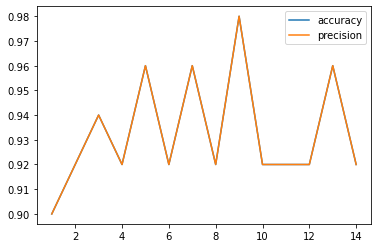

In [23]:
# load the Iris dataset
dataSet = datasets.load_iris()

# Shuffle our input data
randomState=24 # change the state with the numeric parts of your matrikelnummer; if you are in a group, use the sume of the numeric parts
data, target = shuffle(dataSet.data, dataSet.target, random_state=randomState)

testvalues = range(1,15)

# Prepare dataframe for results
knn_results_iris = pd.DataFrame(columns=['accuracy','precision','time training', 'time testing'], index=testvalues)

# Prepare a train/test set split
# split 2/3 1/3 into training & test set
# We use the random number generator state +1; this will influence how our data is split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

# parameters for k-NN
n_neighbors = testvalues

for n in n_neighbors:
    # train the k-NN
    classifier = neighbors.KNeighborsClassifier(n)
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics
    acc=metrics.accuracy_score(y_test, y_test_predicted)
    precision=metrics.precision_score(y_test, y_test_predicted, average="micro")

    knn_results_iris.loc[n] = pd.Series({
        'accuracy':acc,
        'precision':precision,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })

display(knn_results_iris)
knn_results_iris[['accuracy','precision']].plot.line()

### Handwritten Numbers

,accuracy,precision,time training,time testing
1,0.9,0.9,0,0.0030241
2,0.92,0.92,0.000988722,0.00202179
3,0.94,0.94,0,0.00196719
4,0.92,0.92,0,0.00299382
5,0.96,0.96,0.000997543,0.00199461
6,0.92,0.92,0,0.00199509
7,0.96,0.96,0,0.00198102
8,0.92,0.92,0,0.00199389
9,0.98,0.98,0,0.0019958
10,0.92,0.92,0,0.0029912


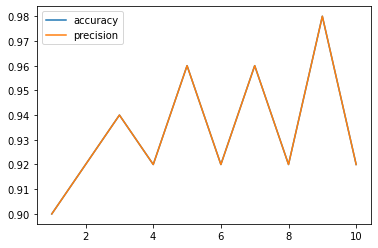

In [24]:
# load the digit dataset
dataSet = datasets.load_iris()

# Shuffle our input data
randomState=24 # change the state with the numeric parts of your matrikelnummer; if you are in a group, use the sume of the numeric parts
data, target = shuffle(dataSet.data, dataSet.target, random_state=randomState)

testvalues = range(1,11)

# Prepare dataframe for results
knn_results_numbers = pd.DataFrame(columns=['accuracy','precision','time training', 'time testing'], index=testvalues)

# Prepare a train/test set split
# split 2/3 1/3 into training & test set
# We use the random number generator state +1; this will influence how our data is split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

# parameters for k-NN
n_neighbors = testvalues

for n in n_neighbors:
    # train the k-NN
    classifier = neighbors.KNeighborsClassifier(n)
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics
    acc=metrics.accuracy_score(y_test, y_test_predicted)
    precision=metrics.precision_score(y_test, y_test_predicted, average="micro")

    knn_results_numbers.loc[n] = pd.Series({
        'accuracy':acc,
        'precision':precision,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })

display(knn_results_numbers)
knn_results_numbers[['accuracy','precision']].plot.line()

# Example Code

In [2]:
# load the Iris dataset
dataSet = datasets.load_iris()


# Shuffle our input data
randomState=24 # change the state with the numeric parts of your matrikelnummer; if you are in a group, use the sume of the numeric parts
data, target = shuffle(dataSet.data, dataSet.target, random_state=randomState)

# Prepare a train/test set split
# split 2/3 1/3 into training & test set
# We use the random number generator state +1; this will influence how our data is split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

# parameters for k-NN
n_neighbors = 15

# train the k-NN
classifier = neighbors.KNeighborsClassifier(n_neighbors)
start_time_train = time.time()
classifier.fit(X_train, y_train)
end_time_train = time.time()

# predict the test set on our trained classifier
start_time_test = time.time()
y_test_predicted = classifier.predict(X_test)
end_time_test = time.time()

# Compute metrics
acc=metrics.accuracy_score(y_test, y_test_predicted)
precision=metrics.precision_score(y_test, y_test_predicted, average="micro")

print("accuracy: " + str(acc))
print("precision: " + str(precision))
print("time training: " + str(end_time_train-start_time_train) + " seconds")
print("time training: " + str(end_time_test-start_time_test) + " seconds")


accuracy: 0.92
precision: 0.92
time training: 0.0009970664978027344 seconds
time training: 0.0019943714141845703 seconds
